In [3]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
import tensorflow as tf
import os

In [4]:
import tensorflow as tf
train_dir = 'data/training'
test_dir = 'data/testing'
batch_size = 64
img_size = 128
validation_split = 0.1
model_save_dir = "Models/None_Models"  # Directory where models/graph will be saved
class_names = 'None'

In [5]:
def normalize(image, label):
    return image / 255.0, label

def normalize_images(image):
    return image / 255.0



In [6]:
#training set
training_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="training",
    label_mode="int",
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size)

# Validation set
validation_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="validation",
    label_mode="int",
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size)

test_set = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode=None,  # No labels for test set
    seed=100,
    image_size=(img_size, img_size),
    batch_size=1)


Found 3462 files belonging to 1 classes.
Using 3116 files for training.
Found 3462 files belonging to 1 classes.
Using 346 files for validation.
Found 100 files belonging to 1 classes.


None


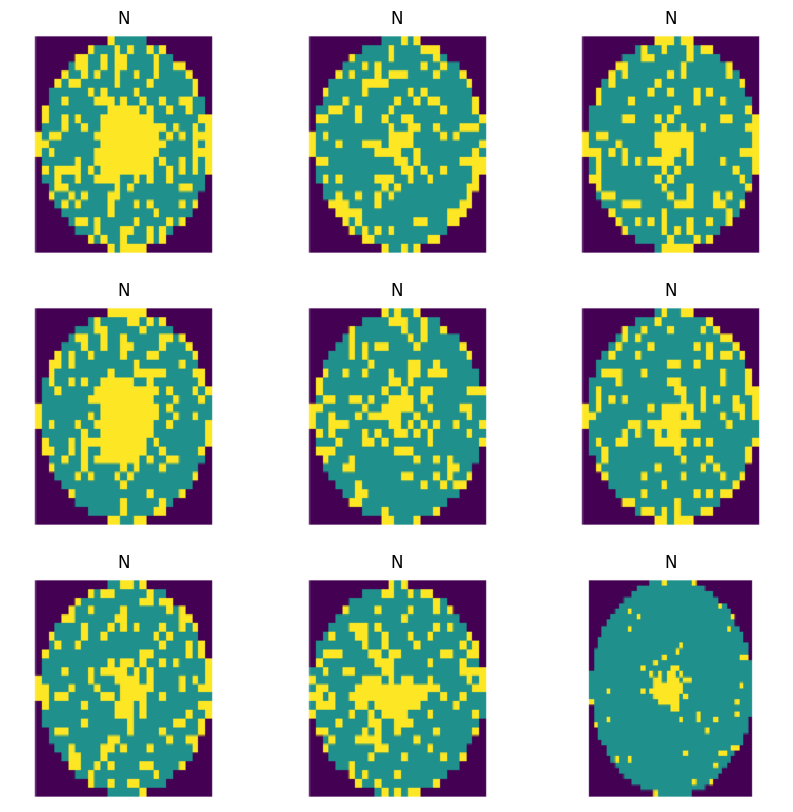

In [7]:
import matplotlib.pyplot as plt
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
training_set = training_set.map(normalize)
validation_set = validation_set.map(normalize)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define input shape and latent dimension
latent_dim = 2
input_shape = (img_size, img_size, 3)
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Sampling function
@tf.function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Reparameterization trick
z = Lambda(sampling)([z_mean, z_log_var])

# Decoder network
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same', )(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Define the VAE loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
B = 1000
vae_loss = K.mean(B * reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(kl_loss, name="kl_loss")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")
vae.compile(optimizer='adam')




In [ ]:
#training
epochs = 1000
save_interval = 50  # Interval at which you want to save the model


# Lists to store loss values
train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training for one epoch
    history = vae.fit(training_set, epochs=1, verbose=1, validation_data=validation_set)
    #history = vae.fit(training_set, epochs=1, verbose=1)

    # Store loss values
    train_losses.append(history.history['loss'][0])
    if 'val_loss' in history.history:
        val_losses.append(history.history['val_loss'][0])

    # Check if it's time to save the model
    if (epoch + 1) % save_interval == 0 or (epoch + 1) == epochs:
        save_path = os.path.join(model_save_dir, f"vae_None_epoch_{epoch+1:02d}.h5")
        print(f"Saving model to {save_path}")
        vae.save(save_path)

import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss for None')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# Save the plot to a file in the same directory as your models
plot_save_path = os.path.join(model_save_dir, "training_validation_loss_None.png")
plt.savefig(plot_save_path)
plt.close()

print(f"Loss plot saved to {plot_save_path}")


In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss for None')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# Save the plot to a file in the same directory as your models
plot_save_path = os.path.join(model_save_dir, "training_validation_loss_None.png")
plt.savefig(plot_save_path)
plt.close()

print(f"Loss plot saved to {plot_save_path}")

Loss plot saved to Models/None_Models/training_validation_loss_None.png


In [10]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf

# Sampling function
@tf.function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon


# Define img_size based on your model
img_size = 128

# Path to the directory containing the saved models
models_directory = "/content/drive/MyDrive/VAE_ML_Project/Models/Center_Models"

# Iterate over every 10th model
for epoch in range(50, 1001, 50):
    # Construct the model path
    model_path = os.path.join(models_directory, f"vae_epoch_{epoch}.h5")

    # Load the model
    vae = load_model(model_path, custom_objects={'sampling': sampling})

    # Create a folder for the current model
    output_folder = os.path.join("/content/drive/MyDrive/VAE_ML_Project/Center_Images", f"Center_Epoch{epoch}_Images")
    os.makedirs(output_folder, exist_ok=True)

    # Process all images in the test set
    for i, x in enumerate(test_set):
        # Normalize images for prediction
        x_norm = x / 255.0

        # Predict with the VAE model and store decoded images
        decoded_batch = vae.predict(x_norm)

        # Save the reconstructed image
        reconstructed_path = os.path.join(output_folder, f"reconstructed_img_{i}.png")
        plt.imsave(reconstructed_path, decoded_batch[0].reshape(img_size, img_size, 3))

        # Break the loop after saving 100 images for each model
        if i == 99:
            break

1/1 [==============================] - 0s 25ms/step


# FID and KID

In [ ]:
import torch
from torchvision.models import inception_v3
from torchvision import transforms
from scipy.linalg import sqrtm
import numpy as np
from torch.nn.functional import adaptive_avg_pool2d
from sklearn.metrics import pairwise_kernels
from torchvision import transforms
from PIL import Image
import glob
import os
import pandas as pd
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    # Ensure covariance matrices are 2D arrays
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    # Calculate FID using the formula
    fid = np.sum((mu1 - mu2)**2) + np.trace(sigma1 + sigma2 - 2 * sqrtm(sigma1 @ sigma2))
    return fid.real

def calculate_kernel_distance(features_real, features_generated, kernel='linear'):
    # Reshape features to 2D arrays
    features_real = np.reshape(features_real, (len(features_real), -1))
    features_generated = np.reshape(features_generated, (len(features_generated), -1))

    # Calculate KID using the specified kernel
    if kernel == 'linear':
        return np.mean(pairwise_kernels(features_real, features_generated, metric='linear'))
    elif kernel == 'rbf':
        return np.mean(pairwise_kernels(features_real, features_generated, metric='rbf'))
    else:
        raise ValueError("Unsupported kernel. Supported kernels are 'linear' and 'rbf'.")

def calculate_activation_statistics(features):
    # Calculate mean and covariance of the features
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

def preprocess_image(img_path):
    # Open the image using PIL
    img = Image.open(img_path)

    # Convert to RGB if the image has an alpha channel
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    # Preprocess image to match Inception-v3 requirements
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension
    return img

def calculate_fid_kid(real_images, generated_images, device='cuda', batch_size=50):
    # Load Inception-v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    # Calculate Inception-v3 features for real images
    real_features = []
    with torch.no_grad():
        for i in range(0, len(real_images), batch_size):
            batch = real_images[i:i+batch_size].to(device)
            features = inception_model(batch)[0].squeeze().cpu().numpy()
            real_features.append(features)
    real_features = np.concatenate(real_features, axis=0)

    # Calculate Inception-v3 features for generated images
    generated_features = []
    with torch.no_grad():
        for i in range(0, len(generated_images), batch_size):
            batch = generated_images[i:i+batch_size].to(device)
            features = inception_model(batch)[0].squeeze().cpu().numpy()
            generated_features.append(features)
    generated_features = np.concatenate(generated_features, axis=0)

    # Calculate FID and KID scores
    mu_real, sigma_real = calculate_activation_statistics(real_features)
    mu_generated, sigma_generated = calculate_activation_statistics(generated_features)

    fid = calculate_frechet_distance(mu_real, sigma_real, mu_generated, sigma_generated)
    kid = calculate_kernel_distance(real_features, generated_features)

    return fid, kid

def load_and_preprocess_images_from_folder(folder):
    # Load and preprocess only .png files from the specified folder
    file_paths = glob.glob(os.path.join(folder, '*.png'))

    images = []
    for img_path in file_paths:
        try:
            img = preprocess_image(img_path)
            images.append(img)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    if not images:
        raise ValueError("No valid images found in the folder.")

    return torch.cat(images, dim=0)  # Use torch.cat instead of torch.stack


def calculate_fid_kid_for_epochs(real_folder, generated_base_folder, epochs, excel_path='FID_KID_scores_Center.csv'):
    # Check if the Excel file already exists
    if os.path.exists(excel_path):
        # If it exists, read the existing data
        df = pd.read_csv(excel_path)
    else:
        # If it doesn't exist, create an empty DataFrame
        df = pd.DataFrame(columns=['Epoch', 'FID', 'KID'])

    # Iterate over each epoch
    for epoch in epochs:
        epoch_folder_name = f'Center_Epoch{epoch}_Images'
        generated_images_folder = os.path.join(generated_base_folder, epoch_folder_name)

        # Load real images
        real_images = load_and_preprocess_images_from_folder(real_folder)

        # Load generated images for the current epoch
        try:
            generated_images = load_and_preprocess_images_from_folder(generated_images_folder)
        except ValueError as e:
            print(f"Skipping Epoch {epoch}: {e}")
            continue

        # Calculate FID and KID for the current epoch
        fid, kid = calculate_fid_kid(real_images, generated_images)

        # Append the results to the DataFrame
        new_row = {'Epoch': epoch, 'FID': fid, 'KID': kid}
        df = df.append(new_row, ignore_index=True)

        print(f"Epoch {epoch} - FID: {fid}, KID: {kid}")

    # Save the DataFrame to the CSV file
    df.to_csv(excel_path, index=False)

# Specify the paths for real images and generated images base folder
real_folder = '/content/drive/MyDrive/VAE_ML_Project/data/testing/Center'
generated_base_folder = '/content/drive/MyDrive/VAE_ML_Project/Center_Images'

# Specify the range of epochs to calculate
epochs_to_calculate = range(50, 1001, 50)  # Adjust as needed

calculate_fid_kid_for_epochs(real_folder, generated_base_folder, epochs_to_calculate)



# PSNR

In [21]:
import torch
import os
from PIL import Image
import numpy as np
import pandas as pd

def calculate_psnr(img1, img2, max_value=255):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 20 * torch.log10(max_value / torch.sqrt(mse))

def load_images(image_folder):
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
    images = {}
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = torch.tensor(np.array(Image.open(image_path).convert("RGB"))).float() / 255.0
        images[image_file] = image.permute(2, 0, 1)  # Convert to CxHxW
    return images

def psnr_fn(epoch_number, real_images, base_folder):
    fake_image_folder = os.path.join(base_folder, f"Near_full_{epoch_number}Epoch_Images")
    fake_images = load_images(fake_image_folder)

    all_psnr_values = []

    for fake_image in fake_images.values():
        psnr_values = []
        for real_image in real_images.values():
            # Check image dimensions and resize if needed
            if fake_image.shape[1:] != (128, 128):
                fake_image_resized = torch.nn.functional.interpolate(fake_image.unsqueeze(0), size=(128, 128), mode='bilinear').squeeze(0)
            else:
                fake_image_resized = fake_image

            if real_image.shape[1:] != (128, 128):
                real_image_resized = torch.nn.functional.interpolate(real_image.unsqueeze(0), size=(128, 128), mode='bilinear').squeeze(0)
            else:
                real_image_resized = real_image

            # Calculate PSNR for each color channel
            psnr_channel = [calculate_psnr(fake_image_resized[c], real_image_resized[c], max_value=1.0).item() for c in range(3)]  # Assuming RGB images
            average_psnr_channel = sum(psnr_channel) / len(psnr_channel)
            psnr_values.append(average_psnr_channel)

        # Calculate the average PSNR for this fake image across all real images
        average_psnr = sum(psnr_values) / len(psnr_values) if psnr_values else 0
        all_psnr_values.append(average_psnr)

    # Calculate the overall average PSNR for all fake images
    overall_average_psnr = sum(all_psnr_values) / len(all_psnr_values) if all_psnr_values else 0
    print("Avg Psnr for epoch: ", epoch_number, " is ", overall_average_psnr)
    return overall_average_psnr

# Load real images once
real_image_folder = "/content/drive/MyDrive/VAE_ML_Project/data/testing/Near-full"  # Update with your path
real_images = load_images(real_image_folder)

# Base folder for fake images
base_fake_images_folder = "/content/drive/MyDrive/VAE_ML_Project/Near_full_Data"  # Update with your base folder path

# Calculate PSNR for each epoch
epochs = range(50, 501, 50)
avg_psnr = [psnr_fn(epoch, real_images, base_fake_images_folder) for epoch in epochs]

# Save to CSV
file_name = 'output_psnr_Near-Full.csv'
pd.DataFrame({'Epochs': list(epochs), 'Average PSNR': avg_psnr}).to_csv(file_name, index=False)
print(f'Data has been saved to {file_name}')

Avg Psnr for epoch:  50  is  9.960247474829355
Avg Psnr for epoch:  100  is  11.587920905812583
Avg Psnr for epoch:  150  is  11.174464689016345
Avg Psnr for epoch:  200  is  10.997277853600183
Avg Psnr for epoch:  250  is  10.614311652342478
Avg Psnr for epoch:  300  is  11.108592232322696
Avg Psnr for epoch:  350  is  11.539999063158039
Avg Psnr for epoch:  400  is  11.003155307817458
Avg Psnr for epoch:  450  is  5.719585330661136
Avg Psnr for epoch:  500  is  6.046778285121914
Data has been saved to output_psnr_Near-Full.csv


# INCEPTION

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.models import inception_v3
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import numpy as np
import pandas as pd
import re

# Define the Inception model
class InceptionModel(nn.Module):
    def __init__(self):
        super(InceptionModel, self).__init__()
        self.inception_model = inception_v3(pretrained=True, transform_input=False)
        self.inception_model.eval()

    def forward(self, x):
        return self.inception_model(x)[0]

# Define the function to calculate the Inception Score
def calculate_inception_score(images, batch_size=32, resize=True):
    # Set up the Inception model
    inception_model = InceptionModel()

    # Check if there are subdirectories
    subdirectories = [f for f in os.listdir(images) if os.path.isdir(os.path.join(images, f))]

    if subdirectories:
        # Use ImageFolder approach if subdirectories are present
        transform = transforms.Compose([
            transforms.Resize((299, 299)) if resize else transforms.ToTensor(),
            transforms.ToTensor(),
        ])

        dataset = ImageFolder(root=images, transform=transform)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        # Compute activations for the generated images
        all_activations = []

        with torch.no_grad():
            for batch in dataloader:
                batch = batch[0]
                activations = inception_model(batch)
                all_activations.append(activations.cpu().numpy())

        all_activations = np.concatenate(all_activations, axis=0)
    else:
        # Direct loading approach if no subdirectories
        # Get the list of image file paths
        image_files = [os.path.join(images, img) for img in os.listdir(images) if img.endswith(('.png', '.jpg', '.jpeg', '.gif'))]

        # Set up data loader for generated images
        transform = transforms.Compose([
            transforms.Resize((299, 299)) if resize else transforms.ToTensor(),
            transforms.ToTensor(),
        ])

        # Load images
        all_images = []
        for img_path in image_files:
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img)
            all_images.append(img_tensor)

        if not all_images:
            raise ValueError("No images found in the specified directory.")

        all_activations = torch.stack(all_images)

    # Compute the Inception Score
    scores = []
    split_size = 10
    all_activations_tensor = torch.tensor(all_activations)
    split_activations = torch.split(all_activations_tensor, len(all_activations_tensor) // split_size)

    for activations in split_activations:
        activations = activations.view(-1, activations.shape[-1])
        scores.append(F.softmax(activations, dim=1))

    scores = torch.cat(scores, dim=0)
    kl_divergence = scores * (torch.log(scores) - torch.log(torch.mean(scores, dim=0)))
    final_score = torch.exp(torch.mean(torch.sum(kl_divergence, dim=1)))

    return final_score.item()

# Path to the folder containing generated images for different epochs
generated_images_base_folder = "/content/drive/MyDrive/VAE_ML_Project/Center_Images"

# CSV file to store Inception Scores
csv_file_path = 'inception_scores_Center.csv'

# Create an empty DataFrame to store results
df_combined = pd.DataFrame(columns=['Epoch', 'Inception_Score'])

# Iterate over each subfolder corresponding to different epochs
for epoch_folder in sorted(os.listdir(generated_images_base_folder), key=lambda x: int(re.search(r'(\d+)', x).group(0)) if re.search(r'(\d+)', x) else float('inf')):
    epoch_folder_path = os.path.join(generated_images_base_folder, epoch_folder)

    # Check if it is a directory
    if os.path.isdir(epoch_folder_path):
        try:
            # Calculate Inception Score for each epoch
            inception_score = calculate_inception_score(epoch_folder_path)

            # Append the new Inception Score to the DataFrame
            df_combined = pd.concat([df_combined, pd.DataFrame({'Epoch': [epoch_folder], 'Inception_Score': [inception_score]})], ignore_index=True)

        except ValueError as e:
            print(f"Skipping {epoch_folder}: {e}")

# Save to CSV
df_combined.to_csv(csv_file_path, index=False)

print("Inception Scores calculation completed and saved to CSV.")

